In [80]:
import os
import ast

import numpy as np
import pandas as pd
import pysgpp as pysgpp
from sklearn.model_selection import train_test_split

from pysgpp.extensions.datadriven.learner import Types
from pysgpp.extensions.datadriven.learner import LearnerBuilder
from pysgpp.extensions.datadriven.uq.plot.plot1d import plotSG1d
from pysgpp.extensions.datadriven.uq.plot.plot2d import plotSG2d,plotGrid2d
from pysgpp.extensions.datadriven.uq.plot.plot3d import plotSG3d
from pysgpp.extensions.datadriven.uq.plot.plotGrid import plotGrid
from pysgpp.extensions.datadriven.learner.folding import RandomFoldingPolicy

#from learner.builder.RegressorSpecificationDescriptor.FoldingStrategy import RANDOM

import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#filename = 'output_100_configs.csv'
#filename = '2D_param_space_times.csv'
filename = '1000_runs_8D_param_room.csv'


df = pd.read_csv(filename, header = None, names = ['params', 'time'])
df.params = df.params.apply(ast.literal_eval)

for param in df.iloc[0].params.keys():
    df[param] = df.params.apply(lambda row: row[param])
    
df['density'] = (df.MOL_X*df.MOL_Y)/(df.DOMAIN_SIZE_X*df.DOMAIN_SIZE_Y)
del df['params']
df = df[df.time > 0]

In [3]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
columns = ['DOMAIN_SIZE_X', 'DOMAIN_SIZE_Y', 'MOL_X', 'MOL_Y', 'LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y',
          'BLOCK_SIZE', 'CUTOFF_RADIUS', 'density','time']

In [5]:
params_ = ['CUTOFF_RADIUS', 'density', 'MOL_Y','MOL_X','DOMAIN_SIZE_Y'
          ,'DOMAIN_SIZE_X','MOL_X','LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y']

In [6]:
params_2 = ['density','LINKED_CELL_SIZE_Y']

In [7]:
params_4 = ['density','CUTOFF_RADIUS']

In [8]:
#df[df.time > 0][params_]

In [9]:
normalized_df = normalize(df[df.time > 0][columns])
train, test = train_test_split(normalized_df, test_size=0.2)
num_samples = train.shape[0]

In [10]:
X_train = train[params_].values
Y_train = train['time'].values

In [11]:
X_test = test[params_].values
Y_test = test['time'].values

In [12]:
X_train.shape

(599, 9)

In [13]:
for levels in range(1, 3):
    builder = LearnerBuilder()
    builder.buildRegressor()
    builder.withTrainingDataFromNumPyArray(X_train, Y_train)
    builder.withTestingDataFromNumPyArray(X_test, Y_test)
    builder = builder.withGrid().withBorder(Types.BorderTypes.NONE)
    builder.withLevel(levels)
    builder = builder.withSpecification()
    builder.withLambda(0.000001).withAdaptPoints(100)
    
    #builder.withRandomFoldingPolicy().withLevel(4)

    builder.withIdentityOperator()
    builder = builder.withStopPolicy()
    builder = builder.withCGSolver()
    builder.withAccuracy(0.0001)
    builder.withImax(1000)
    learner = builder.andGetResult()

    #learner.learnData()
    #learner.learnDataWithFolding()
    learner.learnDataWithTest()
    print 'Test accuracy:' + str(learner.testAccuracy)
    print 'Level: %i' % levels
    print 'L2Norm: %f' % learner.getL2NormError()
    print 'MaxError: %f' % learner.getMaxError()
    print 'MinError: %f' % learner.getMinError()
    print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
    print 'RMSerror: %f' % learner.error.RMSNorm()
    print 'Grid size BEFORE refinement: %i' % learner.grid.getSize()
    print 'Refining grid.. '
    learner.refineGrid()
    learner.learnData()
    print 'Grid size AFTER refinement: %i' % learner.grid.getSize()
    print 'Test accuracy:' + str(learner.testAccuracy)
    print 'L2Norm: %f' % learner.getL2NormError()
    print 'MaxError: %f' % learner.getMaxError()
    print 'MinError: %f' % learner.getMinError()
    print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
    print 'RMSerror: %f' % learner.error.RMSNorm()
    print '--------------------------------------------'

Test accuracy:[0.025725878272586558]
Level: 1
L2Norm: 1.964404
MaxError: 0.721075
MinError: 0.000150
Error: 0.018054
RMSerror: 0.062151
Grid size BEFORE refinement: 1
Refining grid.. 
Grid size AFTER refinement: 19
Test accuracy:[0.025725878272586558]
L2Norm: 1.453694
MaxError: 0.506199
MinError: 0.000053
Error: 0.003528
RMSerror: 0.014832
--------------------------------------------
Test accuracy:[0.006718587689290486]
Level: 2
L2Norm: 1.003887
MaxError: 0.424142
MinError: 0.001226
Error: 0.003528
RMSerror: 0.014832
Grid size BEFORE refinement: 19
Refining grid.. 
Grid size AFTER refinement: 199
Test accuracy:[0.006718587689290486]
L2Norm: 0.807324
MaxError: 0.250577
MinError: 0.000096
Error: 0.001088
RMSerror: 0.004199
--------------------------------------------


In [82]:
def generatePairPlots(X, y, grid, alpha, outdir = None):
    n = X.shape[0]
    time_estimations = []
    p = pysgpp.DataVector(len(params_))
    for i in range(n):
        for j, v in enumerate(X[i,]):
            p[j] = v
        opEval = pysgpp.createOperationEval(grid)
        time_estimations.append(opEval.eval(alpha, p))

    for i, p in enumerate(params_):
        plt.figure()
        plt.xlabel(p)
        plt.ylabel('time')
        plt.scatter(X[:,i], y, color = 'b')
        sorted_test, sorted_estimations = zip(*sorted(zip(X[:,i], time_estimations)))
        plt.plot(sorted_test, sorted_estimations, color = 'r', linestyle = '-.')
        if outdir:
            plt.savefig(os.path.join(outdir, p + '.png'))

In [84]:
os.cwd()

AttributeError: 'module' object has no attribute 'cwd'

IOError: [Errno 2] No such file or directory: '~/sparse-grids/pairPlots/test/CUTOFF_RADIUS.png'

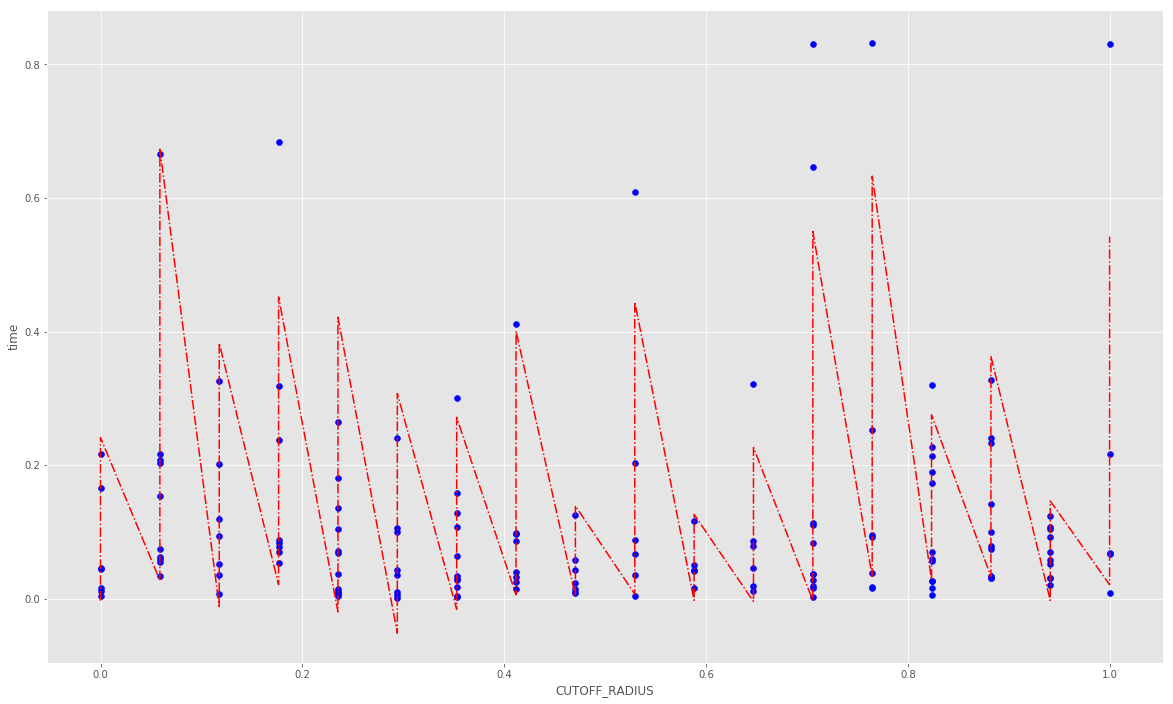

In [83]:
generatePairPlots(X_test, Y_test, learner.grid, learner.alpha, outdir = '~/sparse-grids/pairPlots/test')

In [ ]:
generatePairPlots(X_train, Y_train, learner.grid, learner.alpha, outdir = '~/sparse-grids/pairPlots/train')